In [1]:
import sys
sys.path.append(r'C:\Users\Jameshuckle\Dropbox\My-Portfolio\AlgorithmicTrading\utils')
from data_util import (download_data_local_check, prep_stock_data, prep_fx_data, calc_sharpe,
                       calc_romad, create_dataset, deep_learning_dataset, display_stop_target)
from candlestick_embeddings_util import create_candlestick_corpus

from tqdm import tqdm_notebook as tqdm
from win10toast import ToastNotifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import random
import shutil
import time
import copy
import gc
import os
import gc

%matplotlib inline

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import initializers
from sklearn.metrics import (mean_squared_error, accuracy_score)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy import interpolate

In [3]:
# def global_set_seed(seed_value):
#     os.environ['PYTHONHASHSEED']=str(seed_value)
#     random.seed(seed_value)
#     np.random.seed(seed_value)
#     tf.random.set_seed(seed_value)
# global_set_seed(0)

np.random.seed = 1

In [4]:
data_source = 'fx' # 'fx', 'stock'

if data_source == 'fx':
    ### FX data #######
    fx_files = [
                 'EURUSD_1h_2003-2010.csv', #'EURUSD_1h_2010-2020.csv',
                 'USDJPY_1h_2003-2010.csv', 'USDJPY_1h_2010-2020.csv',
                 'NZDUSD_1h_2003-2020.csv',
                 'AUDUSD_1h_2003-2020.csv',
                 'USDCAD_1h_2003-2020.csv',
                 ]

    loaded_files = prep_fx_data(fx_files)
        
if data_source == 'stock':
    ### stock data ######
    start = '2000-01-01'
    end = '2020-04-28'
    ## download data
    all_stock_data = download_data_local_check('SP500', start, end)
    loaded_files = prep_stock_data(all_stock_data, filter_start_date_tuple=None) #(2015,1,1)

EURUSD_1h_2003-2010.csv
USDJPY_1h_2003-2010.csv
USDJPY_1h_2010-2020.csv
NZDUSD_1h_2003-2020.csv
AUDUSD_1h_2003-2020.csv
USDCAD_1h_2003-2020.csv


In [5]:
def save_numpy_to_csv_all_files(var):
    (x, y, x_test, y_test, train_data_raw, test_data_raw,
     all_data) = deep_learning_dataset(var, train_validation=var.train_validation) 
    pd.concat([x,y], axis=1).to_csv('all_data_train.csv', mode='w', header=True, index=False)
    pd.concat([x_test, y_test], axis=1).to_csv('all_data_test.csv', mode='w', header=True,
                                              index=False)
    gc.collect()

# def save_numpy_to_csv_all_files():
#     header = True
#     mode = 'w'
#     now = time.time()
#     for file_name in tqdm(list(loaded_files.keys())):
#         print('saving',file_name)
#         (x, y, x_test, y_test, y_pct_diff, y_test_pct_diff, train_data_raw,
#          test_data_raw) = create_dataset(file_name=file_name, var=var)
#         my_shape_x = x.shape
#         all_data = pd.DataFrame(x.reshape(-1, my_shape_x[1] * my_shape_x[2]))
#         all_data['y'] = y
#         all_data.to_csv('all_data_train.csv', mode=mode, header=header, index=False)

#         my_shape_x_test = x_test.shape
#         all_data = pd.DataFrame(x_test.reshape(-1, my_shape_x_test[1] * my_shape_x_test[2]))
#         all_data['y'] = y_test
#         all_data.to_csv('all_data_test.csv', mode=mode, header=header,  index=False)
#         header = False
#         mode = 'a'
#         gc.collect()
#     print('finished in:',int(time.time() - now), 'seconds')

def write_csv_to_tfrecords(file_name_no_extension):
    ### Read csv into pandas and save to tfrecords
        csv = pd.read_csv(f'{file_name_no_extension}.csv').values
        with tf.io.TFRecordWriter(f'{file_name_no_extension}.tfrecords') as writer:
            for row in tqdm(csv):
                features, label = row[:-1], row[-1]
                example = tf.train.Example()
                example.features.feature["features"].float_list.value.extend(features)
                example.features.feature["label"].float_list.value.append(label)
                writer.write(example.SerializeToString())
        
def parse_tfrecord(serialized_example):
    input_vector_size = vector_size if var.embeddings else len(var.cols)
    feature_description = {
        'features': tf.io.FixedLenFeature(shape=(input_len, input_vector_size), dtype=tf.float32),
        'label': tf.io.FixedLenFeature(shape=(1), dtype=tf.float32),
    }
    example = tf.io.parse_single_example(serialized_example, feature_description)
    #example['features'] = tf.reshape(example['features'], shape=(input_len, len(var.cols)))
    
    return example['features'], example['label']

def create_tfrecord_dataset(file_name_no_extension):
    ### Write csv to tfrecords
    write_csv_to_tfrecords(file_name_no_extension)
    ### Read in single file
    dataset = tf.data.TFRecordDataset(filenames = [f'{file_name_no_extension}.tfrecords'])
#     for row in dataset.take(1):
#         print(parse_tfrecord(row))
    ### Parse files
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=4)
    ### Cache parsed file onto disk
    [os.remove(file) for file in os.listdir() if f'{file_name_no_extension}_cache' in file] # remove old cache files
    dataset = dataset.cache(filename=f'{file_name_no_extension}_cache')
    print('caching:',f'{file_name_no_extension}_cache')
    dataset = dataset.batch(batch_size=batch_size).prefetch( 
        buffer_size=tf.data.experimental.AUTOTUNE) #.shuffle(buffer_size=1024, seed=1)
    return dataset

In [6]:
from tensorflow.keras import layers

seed_value = 1
layer_kwargs = {'kernel_initializer':initializers.glorot_uniform(seed=seed_value),
                'bias_initializer':initializers.Constant(0.1),
               }

def dnn_model(lr1, lr2, drop_rate, input_len, output_layer):
    input_vector_size = vector_size if var.embeddings else len(var.cols)
    model = tf.keras.Sequential([
        layers.Reshape((input_len * input_vector_size,), input_shape=[input_len, input_vector_size]),
        layers.Dense(units=1000, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        layers.Dense(units=1000, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        layers.Dense(units=1000, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        layers.Dense(units=500, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        layers.Dense(units=500, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        layers.Dense(units=500, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        layers.Dense(units=500, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        layers.Dropout(drop_rate),
        layers.Dense(units=500, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        layers.Dropout(drop_rate),
        layers.Dense(units=500, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        layers.Dropout(drop_rate),
        layers.Dense(units=500, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        layers.Dropout(drop_rate),
        layers.Dense(units=500, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        output_layer,
    ])
    return model

def conv1d_model(lr1, lr2, drop_rate, input_len, output_layer):
    model = tf.keras.Sequential([
        layers.Conv1D(filters=10, kernel_size=4, input_shape=[input_len, len(var.cols)], **layer_kwargs),        
        layers.Flatten(),
        layers.Dense(units=10, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        output_layer,
    ])
    return model

def inception1d_model(lr1, lr2, drop_rate, input_len, output_layer):
    input_img = layers.Input(shape=(input_len, 1))

    layer_1 = layers.Conv1D(10, 1, padding='same', activation='relu', **layer_kwargs)(input_img)
    layer_1 = layers.Conv1D(10, 5, padding='same', activation='relu', **layer_kwargs)(layer_1)

    layer_2 = layers.Conv1D(10, 1, padding='same', activation='relu', **layer_kwargs)(input_img)
    layer_2 = layers.Conv1D(10, 10, padding='same', activation='relu', **layer_kwargs)(layer_2)

    layer_3 = layers.MaxPooling1D(3, strides=1, padding='same')(input_img)
    layer_3 = layers.Conv1D(10, 1, padding='same', activation='relu', **layer_kwargs)(layer_3)

    mid_1 = layers.concatenate([layer_1, layer_2, layer_3], axis = 2)
    flat_1 = layers.Flatten()(mid_1)

    dense_1 = layers.Dense(128, activation='relu', **layer_kwargs)(flat_1)
    dense_2 = layers.Dense(64, activation='relu', **layer_kwargs)(dense_1)
    dense_3 = layers.Dense(32, activation='relu', **layer_kwargs)(dense_2)
    output = output_layer(dense_3)
    model = tf.keras.models.Model([input_img], output)
    return model

def lstm_model(lr1, lr2, drop_rate, input_len, output_layer):
    input_vector_size = vector_size if var.embeddings else len(var.cols)
    model = tf.keras.Sequential([
        layers.LSTM(units=300, return_sequences=True, input_shape=[None, input_vector_size], **layer_kwargs),   
        layers.LSTM(units=300, return_sequences=False, **layer_kwargs), 
        #layers.LSTM(units=32, **layer_kwargs), 
        layers.Dense(units=300, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        layers.Dropout(drop_rate),
        layers.Dense(units=300, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        layers.Dropout(drop_rate),
        layers.Dense(units=300, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        layers.Dropout(drop_rate),
        output_layer,
    ])
    return model

In [40]:
class algo_variables():
    pass

var = algo_variables()
var.window = 20 # number of training bars
var.pca_features = False # False, 10
var.standardize = 'std' #'std', 'min_max'
var.norm_by_vol = False #True
var.data_percentage_diff = 'close_diff' # False, 'close_diff', 'ohlc_diff', 'open_diff'
var.data_percentage_diff_y = True
var.train_split = 0.9
var.resample = '1D' # None '1D', '4H', '1W'
var.read_single_file = None #all_files[3] #None
var.loaded_files = loaded_files

var.num_bars = 10 # prediction horizon
var.problem_type = 'binary' #'regression' 'binary' 'category'
var.dataset_type = 'stock' #'wave', 'random', 'stock', 'monte_carlo'
var.cols = ['Open', 'High', 'Low', 'Close'] if var.dataset_type == 'stock' else ['univariate']
#var.cols = ['Close'] if dataset_type in ['stock','monte_carlo'] else ['univariate']
var.multi_y = False

###
input_len = var.pca_features if var.pca_features else var.window
###

## target/stop binary outcomes ##
var.target_stop = False 
if var.target_stop:
    var.num_bars = 1 # must be equal to 1!
    var.problem_type = 'binary'
    var.dataset_type = 'stock'
    var.cols = ['Open', 'High', 'Low', 'Close']
    var.bar_horizon = 10000 # how long to wait for stop or target hit, otherwise assign 1 if in profit or 0 if not
    var.stop_size_pct = 0.0050 # size of stop in pct
    var.target_size_r_r = 1 #at the moment it only makes sense to keep it at 1
    var.tick_size_decimals = 10 # used for rounding (no that important)

var.embeddings = False
var.embedding_type = None #None 'light'
if var.embeddings:
    var.standardize = False 
    var.pca_features = False
    var.vector_size = 200 # 200, 4
    if var.embedding_type == 'light':
        var.vector_size = 1
    
generator = True
if generator: 
    ## save all stocks to csv and tfrecords, then load tfrecords as dataset
    var.train_validation = 0.9 #False # Uses traning data to create test set (for validation)
    save_numpy_to_csv_all_files(var)
    batch_size = 500
    train_dataset = create_tfrecord_dataset('all_data_train')
    test_dataset = create_tfrecord_dataset('all_data_test')
else:
    ### load single stock into numpy
    (x, y, x_test, y_test, y_pct_diff, y_test_pct_diff, train_data_raw,
     test_data_raw) = create_dataset(file_name=list(loaded_files.keys())[0], var=var)


train_validation: 0.9



caching: all_data_train_cache



caching: all_data_test_cache


In [41]:
#display_stop_target(x_test, y_test, start=0, end=300, vline=40, hline=40)
# pd.Series(y_pct_diff).cumsum().plot()

In [42]:
tf.keras.backend.clear_session()

lr1 = 0 #1e-6
lr2 = 0 #1e-5
drop_rate = 0.5 #0.1 #0.2

###################################################################
if var.problem_type == 'binary': 
    output_layer = tf.keras.layers.Dense(units=1, activation='sigmoid', **layer_kwargs)
elif var.problem_type == 'category': 
    output_layer = tf.keras.layers.Dense(units=3, activation='softmax', **layer_kwargs)
else: 
    output_layer = tf.keras.layers.Dense(units=1, activation=None, **layer_kwargs)

###    
    
#model = dnn_model(lr1, lr2, drop_rate, input_len, output_layer)
#model = conv1d_model(lr1, lr2, drop_rate, input_len, output_layer)
#model = inception1d_model(lr1, lr2, drop_rate, input_len, output_layer)
model = lstm_model(lr1, lr2, drop_rate, input_len, output_layer)

###

total_epochs=0
all_history = {}
# delete last saved model
checkpoint_path_base = 'C:\\Users\\Jameshuckle\\Documents\\Algo_Trading\\model_checkpoints'
checkpoint_path_model = checkpoint_path_base+'\\model.ckpt'
if os.path.exists(checkpoint_path_model):
    shutil.rmtree(checkpoint_path_model)

## Train model

In [43]:
checkpoint_path_cb = checkpoint_path_base+'\\model_epoch-{epoch}.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_cb, save_best_only=False,
                                                 save_weights_only=True, monitor='val_accuracy',
                                                 mode='max', verbose=0)

# load model to keep continuity of epochs. To create new model run cell above.
if os.path.exists(checkpoint_path_model):
    print('loading model')
    model = tf.keras.models.load_model(checkpoint_path_model)

############################################################
adam = tf.keras.optimizers.Adam(learning_rate=1e-4)

if var.problem_type == 'binary': 
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
elif var.problem_type == 'category':
    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
else:
    rmse = tf.keras.metrics.RootMeanSquaredError(name='root_mean_squared_error', dtype=None)
    model.compile(optimizer=adam, loss='mse', metrics=[rmse])

gc.collect()

plot_lr_rate = False
decrease_lr_rate = False
validation = True

epochs = 500

kwargs = {'verbose':2, 'epochs':epochs, 'initial_epoch':total_epochs, 'shuffle':False,
          'callbacks':[cp_callback]}
                    
if plot_lr_rate:
    kwargs['callbacks'].append(tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-8 * 10**(epoch / (epochs / 7))))

elif decrease_lr_rate:
    kwargs['callbacks'].append(tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-3 / 10**(epoch / epochs))) #1e-2
    #kwargs['callbacks'].append(tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3))

if validation:   
    if generator:
        kwargs['validation_data'] = test_dataset
    else:
        kwargs['validation_split'] = 0.7

if generator:
    ### Parellelize loading
    history = model.fit(x=train_dataset, **kwargs)
else:
    batch_size = 100
    history = model.fit(x, y, batch_size=batch_size, **kwargs)
                        
model.save(checkpoint_path_model)
print('\n---------------')
total_epochs = epochs
print('\ntotal_epochs',total_epochs)
gc.collect()

for key, value in history.history.items():
    all_history.setdefault(key, [])
    all_history[key] += value
    
# toaster = ToastNotifier()
# toaster.show_toast("Finished Training!", "Hello world", duration=3, threaded=True)

Epoch 1/500
37/37 - 2s - loss: 0.7107 - accuracy: 0.5070 - val_loss: 0.6929 - val_accuracy: 0.5098
Epoch 2/500
37/37 - 1s - loss: 0.7037 - accuracy: 0.5020 - val_loss: 0.6930 - val_accuracy: 0.5054
Epoch 3/500
37/37 - 1s - loss: 0.7013 - accuracy: 0.5022 - val_loss: 0.6929 - val_accuracy: 0.5074
Epoch 4/500
37/37 - 1s - loss: 0.7016 - accuracy: 0.4994 - val_loss: 0.6930 - val_accuracy: 0.5049
Epoch 5/500
37/37 - 1s - loss: 0.6992 - accuracy: 0.5037 - val_loss: 0.6929 - val_accuracy: 0.5059
Epoch 6/500
37/37 - 1s - loss: 0.6990 - accuracy: 0.5002 - val_loss: 0.6929 - val_accuracy: 0.5083
Epoch 7/500
37/37 - 1s - loss: 0.6959 - accuracy: 0.5167 - val_loss: 0.6929 - val_accuracy: 0.5108
Epoch 8/500
37/37 - 1s - loss: 0.6971 - accuracy: 0.5088 - val_loss: 0.6928 - val_accuracy: 0.5010
Epoch 9/500
37/37 - 1s - loss: 0.6960 - accuracy: 0.5126 - val_loss: 0.6929 - val_accuracy: 0.5039
Epoch 10/500
37/37 - 1s - loss: 0.6975 - accuracy: 0.5012 - val_loss: 0.6929 - val_accuracy: 0.5034
Epoch 11/

Epoch 83/500
37/37 - 1s - loss: 0.6840 - accuracy: 0.5314 - val_loss: 0.6943 - val_accuracy: 0.5108
Epoch 84/500
37/37 - 1s - loss: 0.6843 - accuracy: 0.5294 - val_loss: 0.6940 - val_accuracy: 0.5049
Epoch 85/500
37/37 - 1s - loss: 0.6845 - accuracy: 0.5315 - val_loss: 0.6957 - val_accuracy: 0.5123
Epoch 86/500
37/37 - 1s - loss: 0.6834 - accuracy: 0.5282 - val_loss: 0.6934 - val_accuracy: 0.5044
Epoch 87/500
37/37 - 1s - loss: 0.6828 - accuracy: 0.5350 - val_loss: 0.6957 - val_accuracy: 0.5034
Epoch 88/500
37/37 - 1s - loss: 0.6838 - accuracy: 0.5288 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 89/500
37/37 - 1s - loss: 0.6826 - accuracy: 0.5314 - val_loss: 0.6961 - val_accuracy: 0.4995
Epoch 90/500
37/37 - 1s - loss: 0.6804 - accuracy: 0.5365 - val_loss: 0.6955 - val_accuracy: 0.4971
Epoch 91/500
37/37 - 1s - loss: 0.6805 - accuracy: 0.5407 - val_loss: 0.6959 - val_accuracy: 0.4966
Epoch 92/500
37/37 - 1s - loss: 0.6796 - accuracy: 0.5406 - val_loss: 0.6963 - val_accuracy: 0.5029


Epoch 165/500
37/37 - 1s - loss: 0.6216 - accuracy: 0.6088 - val_loss: 0.7594 - val_accuracy: 0.4563
Epoch 166/500
37/37 - 1s - loss: 0.6177 - accuracy: 0.6144 - val_loss: 0.7532 - val_accuracy: 0.4656
Epoch 167/500
37/37 - 1s - loss: 0.6141 - accuracy: 0.6185 - val_loss: 0.7624 - val_accuracy: 0.4592
Epoch 168/500
37/37 - 1s - loss: 0.6120 - accuracy: 0.6192 - val_loss: 0.7416 - val_accuracy: 0.4543
Epoch 169/500
37/37 - 1s - loss: 0.6100 - accuracy: 0.6268 - val_loss: 0.7676 - val_accuracy: 0.4597
Epoch 170/500
37/37 - 1s - loss: 0.6098 - accuracy: 0.6216 - val_loss: 0.7571 - val_accuracy: 0.4514
Epoch 171/500
37/37 - 1s - loss: 0.6094 - accuracy: 0.6237 - val_loss: 0.7713 - val_accuracy: 0.4465
Epoch 172/500
37/37 - 1s - loss: 0.6082 - accuracy: 0.6259 - val_loss: 0.7638 - val_accuracy: 0.4499
Epoch 173/500
37/37 - 1s - loss: 0.6072 - accuracy: 0.6184 - val_loss: 0.7941 - val_accuracy: 0.4568
Epoch 174/500
37/37 - 1s - loss: 0.6086 - accuracy: 0.6309 - val_loss: 0.7819 - val_accurac

Epoch 246/500
37/37 - 1s - loss: 0.4286 - accuracy: 0.7714 - val_loss: 0.9505 - val_accuracy: 0.4686
Epoch 247/500
37/37 - 1s - loss: 0.4242 - accuracy: 0.7747 - val_loss: 0.9433 - val_accuracy: 0.4897
Epoch 248/500
37/37 - 1s - loss: 0.4210 - accuracy: 0.7741 - val_loss: 0.9325 - val_accuracy: 0.4799
Epoch 249/500
37/37 - 1s - loss: 0.4183 - accuracy: 0.7764 - val_loss: 0.9874 - val_accuracy: 0.4858
Epoch 250/500
37/37 - 1s - loss: 0.4185 - accuracy: 0.7744 - val_loss: 0.9852 - val_accuracy: 0.4666
Epoch 251/500
37/37 - 1s - loss: 0.4103 - accuracy: 0.7784 - val_loss: 1.0160 - val_accuracy: 0.4828
Epoch 252/500
37/37 - 1s - loss: 0.3997 - accuracy: 0.7864 - val_loss: 1.0021 - val_accuracy: 0.4867
Epoch 253/500
37/37 - 1s - loss: 0.4041 - accuracy: 0.7863 - val_loss: 1.0033 - val_accuracy: 0.4921
Epoch 254/500
37/37 - 1s - loss: 0.4029 - accuracy: 0.7846 - val_loss: 1.0144 - val_accuracy: 0.4769
Epoch 255/500
37/37 - 1s - loss: 0.3940 - accuracy: 0.7939 - val_loss: 1.0453 - val_accurac

Epoch 327/500
37/37 - 1s - loss: 0.2489 - accuracy: 0.8799 - val_loss: 1.5090 - val_accuracy: 0.4848
Epoch 328/500
37/37 - 1s - loss: 0.2448 - accuracy: 0.8855 - val_loss: 1.4878 - val_accuracy: 0.4936
Epoch 329/500
37/37 - 1s - loss: 0.2501 - accuracy: 0.8807 - val_loss: 1.4579 - val_accuracy: 0.4917
Epoch 330/500
37/37 - 1s - loss: 0.2478 - accuracy: 0.8778 - val_loss: 1.4929 - val_accuracy: 0.4877
Epoch 331/500
37/37 - 1s - loss: 0.2392 - accuracy: 0.8848 - val_loss: 1.5617 - val_accuracy: 0.4877
Epoch 332/500
37/37 - 1s - loss: 0.2448 - accuracy: 0.8831 - val_loss: 1.5437 - val_accuracy: 0.4907
Epoch 333/500
37/37 - 1s - loss: 0.2337 - accuracy: 0.8883 - val_loss: 1.5858 - val_accuracy: 0.4789
Epoch 334/500
37/37 - 1s - loss: 0.2316 - accuracy: 0.8915 - val_loss: 1.6205 - val_accuracy: 0.4853
Epoch 335/500
37/37 - 1s - loss: 0.2288 - accuracy: 0.8932 - val_loss: 1.5888 - val_accuracy: 0.4838
Epoch 336/500
37/37 - 1s - loss: 0.2243 - accuracy: 0.8951 - val_loss: 1.6569 - val_accurac

Epoch 408/500
37/37 - 1s - loss: 0.1190 - accuracy: 0.9490 - val_loss: 2.2784 - val_accuracy: 0.4975
Epoch 409/500
37/37 - 1s - loss: 0.1164 - accuracy: 0.9490 - val_loss: 2.2537 - val_accuracy: 0.4966
Epoch 410/500
37/37 - 1s - loss: 0.1113 - accuracy: 0.9542 - val_loss: 2.2703 - val_accuracy: 0.4956
Epoch 411/500
37/37 - 1s - loss: 0.1245 - accuracy: 0.9465 - val_loss: 2.3785 - val_accuracy: 0.4921
Epoch 412/500
37/37 - 1s - loss: 0.1139 - accuracy: 0.9525 - val_loss: 2.4417 - val_accuracy: 0.4971
Epoch 413/500
37/37 - 1s - loss: 0.1103 - accuracy: 0.9531 - val_loss: 2.2716 - val_accuracy: 0.5059
Epoch 414/500
37/37 - 1s - loss: 0.1133 - accuracy: 0.9516 - val_loss: 2.2953 - val_accuracy: 0.5020
Epoch 415/500
37/37 - 1s - loss: 0.1052 - accuracy: 0.9574 - val_loss: 2.3182 - val_accuracy: 0.4931
Epoch 416/500
37/37 - 1s - loss: 0.1026 - accuracy: 0.9568 - val_loss: 2.3821 - val_accuracy: 0.5103
Epoch 417/500
37/37 - 1s - loss: 0.1029 - accuracy: 0.9567 - val_loss: 2.3971 - val_accurac

Epoch 489/500
37/37 - 1s - loss: 0.0801 - accuracy: 0.9666 - val_loss: 2.6512 - val_accuracy: 0.5093
Epoch 490/500
37/37 - 1s - loss: 0.0767 - accuracy: 0.9692 - val_loss: 2.6463 - val_accuracy: 0.4980
Epoch 491/500
37/37 - 1s - loss: 0.0744 - accuracy: 0.9700 - val_loss: 2.8207 - val_accuracy: 0.4966
Epoch 492/500
37/37 - 1s - loss: 0.0799 - accuracy: 0.9685 - val_loss: 2.7910 - val_accuracy: 0.5020
Epoch 493/500
37/37 - 1s - loss: 0.0839 - accuracy: 0.9666 - val_loss: 2.7053 - val_accuracy: 0.5015
Epoch 494/500
37/37 - 1s - loss: 0.0652 - accuracy: 0.9739 - val_loss: 2.7121 - val_accuracy: 0.4951
Epoch 495/500
37/37 - 1s - loss: 0.0695 - accuracy: 0.9727 - val_loss: 2.7852 - val_accuracy: 0.4980
Epoch 496/500
37/37 - 1s - loss: 0.0612 - accuracy: 0.9759 - val_loss: 2.8093 - val_accuracy: 0.4990
Epoch 497/500
37/37 - 1s - loss: 0.0587 - accuracy: 0.9774 - val_loss: 2.8963 - val_accuracy: 0.5015
Epoch 498/500
37/37 - 1s - loss: 0.0595 - accuracy: 0.9763 - val_loss: 2.9126 - val_accurac

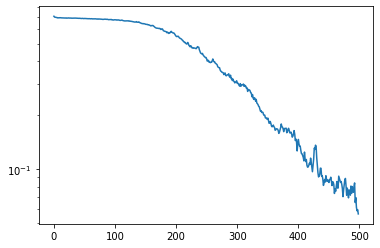

In [44]:
start_epoch = 0
end_epoch = -1

if plot_lr_rate:
    plt.plot(all_history['lr'][start_epoch:end_epoch],
             all_history['loss'][start_epoch:end_epoch])
    plt.xscale('log')
    lowest_loss_idx = np.argmin(all_history['loss'])
    print('best lr:',all_history['lr'][lowest_loss_idx])
elif decrease_lr_rate:
    plt.plot(all_history['lr'][start_epoch:end_epoch],
             all_history['loss'][start_epoch:end_epoch])
    plt.title('learning rate')
    plt.xscale('log')
    plt.xlim(max(all_history['lr'][start_epoch:end_epoch]),
             min(all_history['lr'][start_epoch:end_epoch]))
else:
    plt.plot(all_history['loss'][start_epoch:end_epoch])
    plt.yscale('log')

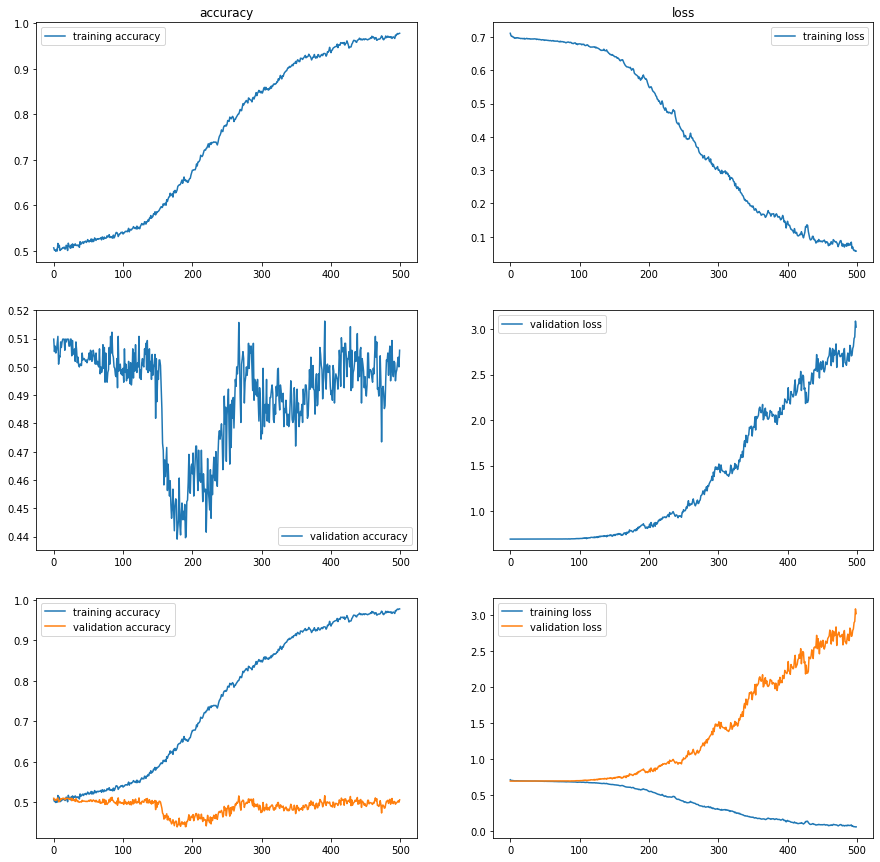

In [45]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,15))

metric = 'accuracy' if var.problem_type == 'regression' else 'accuracy'
epoch_show_from = int(epochs * 0)
# metric
ax[0][0].plot(all_history[metric][epoch_show_from:])
ax[0][0].legend([f'training {metric}'])
ax[0][0].set_title(metric)
# loss
ax[0][1].plot(all_history['loss'][epoch_show_from:])
ax[0][1].legend([f'training loss'])
ax[0][1].set_title('loss')

if validation:
    # metric
    ax[1][0].plot(all_history[f'val_{metric}'][epoch_show_from:])
    ax[1][0].legend([f'validation {metric}'])
    ax[2][0].plot(all_history[metric][epoch_show_from:])
    ax[2][0].plot(all_history[f'val_{metric}'][epoch_show_from:])
    ax[2][0].legend([f'training {metric}',f'validation {metric}'])

    # loss
    ax[1][1].plot(all_history[f'val_loss'][epoch_show_from:])
    ax[1][1].legend([f'validation loss'])
    ax[2][1].plot(all_history['loss'][epoch_show_from:])
    ax[2][1].plot(all_history[f'val_loss'][epoch_show_from:])
    ax[2][1].legend([f'training loss',f'validation loss'])
else:
    ax[2][0].legend(['train'])
    ax[2][1].legend(['train'])
 

In [55]:
man_epoch_idx = 0 #Set to 0 or False to choose best accuracy, otherwise choose epoch to load

if man_epoch_idx:
    print('load weights from epoch', man_epoch_idx)
    checkpoint_path = f'{checkpoint_path_base}\\model_epoch-{man_epoch_idx}.ckpt'
else:
    print('Loaded weights from best val_accuracy')
    best_idx = np.argmax(all_history['val_accuracy'])
    best_acc = round(max(all_history['val_accuracy']),4)
    print(f'best val_accuracy: epoch={best_idx} acc={best_acc}')
    checkpoint_path = f'{checkpoint_path_base}\\model_epoch-{best_idx + 1}.ckpt'
model.load_weights(checkpoint_path)

Loaded weights from best val_accuracy
best val_accuracy: epoch=391 acc=0.5162


In [56]:
#raise Exception('stop at this cell')

In [57]:
def create_review_data_set(review_set):
    if review_set == 'train':
        review_x_data = x 
        review_y_data = y
        review_y_pct_diff = y_pct_diff
    elif review_set == 'test':
        review_x_data = x_test
        review_y_data = y_test
        review_y_pct_diff = y_test_pct_diff
    elif review_set == 'all':
        review_x_data = np.concatenate([x, x_test],axis=0)
        review_y_data = np.concatenate([y, y_test],axis=0)
        review_y_pct_diff = np.concatenate([y_pct_diff, y_test_pct_diff],axis=0)
    return review_x_data, review_y_data, review_y_pct_diff

def format_predictions_tanh(review_x_data):
    raw_predictions = model.predict(review_x_data)
    if var.problem_type == 'binary': 
        predictions_tanh = np.where(raw_predictions.flatten() < 0.5, -1, 1) 
    elif var.problem_type == 'category':
        class_idx = np.argmax(raw_predictions, axis=1)
        predictions_tanh = class_idx - 1
        raw_predictions[:, 0] = -raw_predictions[:, 0] 
        raw_predictions[:, 1] = 0
        raw_predictions = raw_predictions[range(raw_predictions.shape[0]),class_idx]
    else:
        predictions_tanh = raw_predictions.flatten()
    return raw_predictions, predictions_tanh

def cut_off_start_review_data_for_prediction():
    # cut off start of raw data until first prediction candle
    if review_set == 'train':
        review_data_raw = train_data_raw[var.window + var.num_bars -1:]
    elif review_set == 'test':
        review_data_raw = test_data_raw[var.window + var.num_bars -1:]
    elif review_set == 'all':
        review_data_raw = np.concatenate([train_data_raw[var.window + var.num_bars -1:],
                                          test_data_raw[var.window + var.num_bars -1:]],axis=0)
    
    if len(var.cols) != 1:
        review_data_raw = review_data_raw[:,-1]   
    
    return review_data_raw

def see_predictions(review_set): 
    review_x_data, review_y_data, review_y_pct_diff = create_review_data_set(review_set)
    raw_predictions, predictions_tanh = format_predictions_tanh(review_x_data)
    review_data_raw = cut_off_start_review_data_for_prediction()
    return review_data_raw, review_x_data, review_y_data, review_y_pct_diff, raw_predictions, predictions_tanh

pip_fees = 0
review_set = 'test' #'test' 'train' 'all'
dataset_type = 'stock'

file_name = list(loaded_files.keys())[0]
print(file_name)
(x, y, x_test, y_test, y_pct_diff, y_test_pct_diff, train_data_raw,
 test_data_raw) = create_dataset(file_name=file_name, var=var)

(review_data_raw, review_x_data, review_y_data, review_y_pct_diff, raw_predictions,
 predictions_tanh) = see_predictions(review_set)

EURUSD_1h_2003-2010.csv


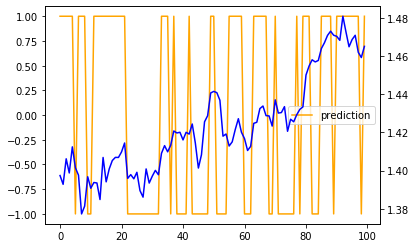

-1 to 1 range: 2


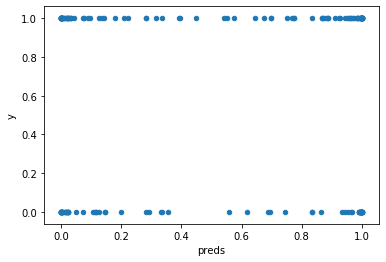

In [58]:
def plot_preds(bars_to_plot):
    fig, ax1 = plt.subplots()
    ax1.plot(predictions_tanh[:bars_to_plot], c='orange')
    ax1.legend(['prediction'])
    ax2 = ax1.twinx()
    ax2.plot(review_data_raw[:bars_to_plot], c='blue')
    #ax2.plot(review_ data_raw[input_len + var.num_bars: input_len + var.num_bars + bars_to_plot],
    #         c='blue')
    plt.show()
    smallest, biggest = predictions_tanh.min(), predictions_tanh.max()
    print(smallest,'to', biggest, 'range:', biggest - smallest )

bars_to_plot = 100
plot_preds(bars_to_plot)

preds = model.predict(x_test)
my_stuff = pd.DataFrame(pd.Series(preds.flatten(), name='preds'))
my_stuff['y'] = y_test
my_stuff.plot.scatter('preds','y')

avg_profit (0 pip fees) 0.0007299379352097824
best possible profit (0 pip fees) 0.01169453027655698


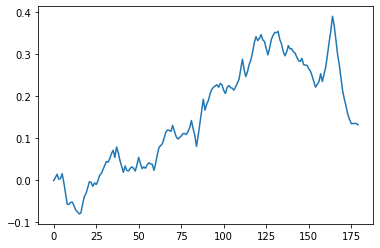

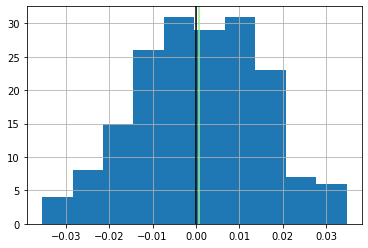

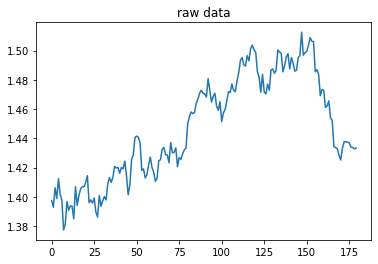

In [59]:
def calc_returns(review_data_raw, predictions_tanh, raw_predictions, review_y_pct_diff, pip_fees=1):
    returns = pd.DataFrame(pd.Series(review_data_raw, name='test_data_raw'))
    returns['y_pct_diff'] = review_y_pct_diff
    returns['predictions_tanh'] = pd.Series(predictions_tanh.flatten())
    returns['raw_predictions'] = pd.Series(raw_predictions.flatten())
    
    if var.problem_type == 'regression':
        returns['predictions_tanh'] = returns['raw_predictions'] - returns['test_data_raw']
        
    longs = returns.query('predictions_tanh > 0')
    flat = returns.query('predictions_tanh == 0')
    shorts = returns.query('predictions_tanh < 0')
    returns.loc[longs.index, 'profit'] = returns.loc[longs.index,'y_pct_diff'] - (0.0001 * pip_fees)
    returns.loc[flat.index, 'profit'] = 0
    returns.loc[shorts.index, 'profit'] = -returns.loc[shorts.index,'y_pct_diff'] - (0.0001 * pip_fees)
    returns['returns'] = returns['profit'].cumsum()
    avg_profit = returns['profit'].mean()
    print(f'avg_profit ({pip_fees} pip fees)',avg_profit)
    print(f'best possible profit ({pip_fees} pip fees)',returns['y_pct_diff'].abs().mean())
        
    return avg_profit, returns

def plot_returns():
    returns['returns'].plot()
    plt.show()
    ##
    ax = returns['profit'].hist()
    ax.axvline(0, c='k')
    ax.axvline(avg_profit, c='lightgreen')
    plt.show()
    
review_data_raw = review_data_raw.flatten()
avg_profit, returns = calc_returns(review_data_raw, predictions_tanh, raw_predictions,
                                   review_y_pct_diff, pip_fees=pip_fees)
plot_returns()

plt.plot(review_data_raw)
plt.title('raw data')
plt.show()

In [60]:
#raise Exception('stop at this cell')

### All files

In [61]:
pip_fees = 1
review_set = 'test' #'test' 'train' ' all'

all_returns = []
all_raw = []
for file_name in tqdm(list(loaded_files.keys())[:]):
    gc.collect()
    print(file_name)
    (x, y, x_test, y_test, y_pct_diff, y_test_pct_diff, train_data_raw,
     test_data_raw) = create_dataset(file_name=file_name, var=var)
    print(x.shape, x_test.shape)
    (review_data_raw, review_x_data, review_y_data, review_y_pct_diff, raw_predictions,
     predictions_tanh) = see_predictions(review_set)
    review_data_raw = review_data_raw.flatten()
    avg_profit, returns = calc_returns(review_data_raw, predictions_tanh, raw_predictions,
                                       review_y_pct_diff, pip_fees=pip_fees)
    num_trades = len(returns)
    print('no. trades:', num_trades)
    if var.resample:
        index_data = loaded_files[file_name].resample(var.resample).agg({'Open':'first',
                                                    'High':'max','Low':'min','Close':'last'})
    else:
        index_data = loaded_files[file_name]
    if review_set in ['train', 'all']:
        returns.index = index_data[:num_trades].index
    elif review_set == 'test':
        returns.index = index_data[-num_trades:].index
    returns['profit'].name=file_name
    returns['y_pct_diff'].name=file_name
    all_returns.append(returns['profit'])
    all_raw.append(returns['y_pct_diff'])

EURUSD_1h_2003-2010.csv
(1849, 20, 4) (180, 20, 4)
avg_profit (1 pip fees) 0.0006299379352097839
best possible profit (1 pip fees) 0.01169453027655698
no. trades: 180
USDJPY_1h_2003-2010.csv
(1848, 20, 4) (180, 20, 4)
avg_profit (1 pip fees) 0.0008608016799445092
best possible profit (1 pip fees) 0.01658324193262585
no. trades: 180
USDJPY_1h_2010-2020.csv
(2805, 20, 4) (286, 20, 4)
avg_profit (1 pip fees) 0.0005501554074328199
best possible profit (1 pip fees) 0.007220908978748762
no. trades: 286
NZDUSD_1h_2003-2020.csv
(4618, 20, 4) (488, 20, 4)
avg_profit (1 pip fees) 0.0017631842463236714
best possible profit (1 pip fees) 0.011951569428496588
no. trades: 488
AUDUSD_1h_2003-2020.csv
(4615, 20, 4) (487, 20, 4)
avg_profit (1 pip fees) -0.0007522554977788808
best possible profit (1 pip fees) 0.010653107979020044
no. trades: 487
USDCAD_1h_2003-2020.csv
(4620, 20, 4) (488, 20, 4)
avg_profit (1 pip fees) 0.0004172979552827262
best possible profit (1 pip fees) 0.007073228812722007
no. trade

suspect high stock trade: {}
suspect low stock trades: {}
averge profit (after 1 pip fees): 0.0005326716283637582


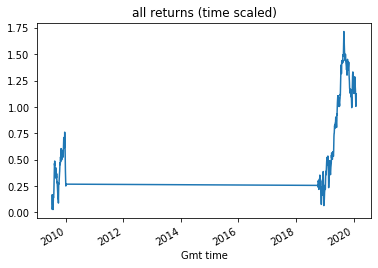

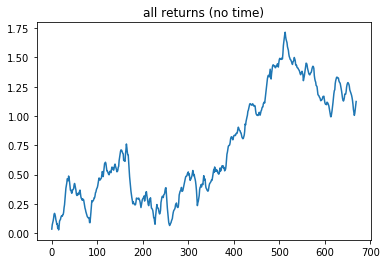

yearly_returns: [ 0.25095917  0.01737396 -0.06366422  1.05272878 -0.13399323]


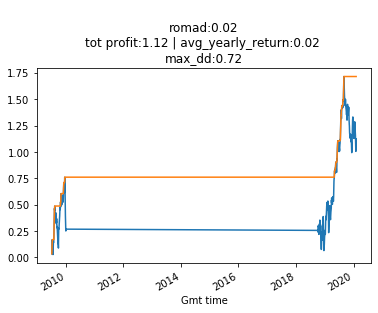

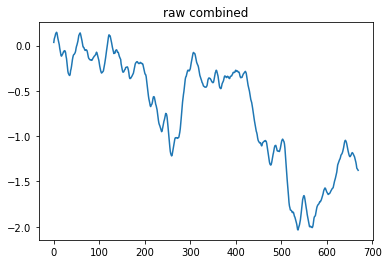

In [62]:
all_returns_final = pd.concat(all_returns, axis=1)
suspect_profits = all_returns_final.max(axis=0).sort_values(ascending=False)
suspect_high_stocks = list(suspect_profits[suspect_profits > 1].index) # larger than 100% gain on any trade
print('suspect high stock trade:', suspect_profits[suspect_profits > 1].round(2).to_dict())
suspect_losses = all_returns_final.min(axis=0).sort_values(ascending=True)
suspect_low_stocks = list(suspect_losses[suspect_losses < -0.5].index) # larger than -50% loss on any trade
print('suspect low stock trades:', suspect_losses[suspect_losses < -0.5].round(2).to_dict())
suspect_stocks = suspect_high_stocks + suspect_low_stocks

all_returns_final.drop(suspect_stocks, axis='columns', inplace=True)  
print(f'averge profit (after {pip_fees} pip fees):',np.nanmean(all_returns_final))
all_returns_final['profit'] = all_returns_final.sum(axis=1)
all_returns_final['returns'] = all_returns_final['profit'].cumsum()
all_returns_final['returns'].plot(title='all returns (time scaled)')
plt.show()
all_returns_final['returns'].reset_index(drop=True).plot(title='all returns (no time)')
plt.show()

romad = calc_romad(all_returns_final['profit'], filter_large_trades=0.5,
                   yearly_agg=np.median, plot=True)

all_raw_final = pd.concat(all_raw, axis=1)
all_raw_final.drop(suspect_stocks, axis='columns', inplace=True) 
all_raw_final.sum(axis=1).cumsum().reset_index(drop=True).plot(title='raw combined')
plt.show()

In [63]:
raise Exception('stop at this cell')

Exception: stop at this cell

### Performance report

In [ ]:
rmse_func = lambda y, y_hat: mean_squared_error(y, y_hat)**0.5
scorer = rmse_func if var.problem_type == 'regression' else accuracy_score

if review_set == 'train':
    y_data = y
elif review_set == 'test':
    y_data = y_test
elif review_set == 'all':
    y_data = np.concatenate([y, y_test],axis=0)

if var.problem_type == 'category':
    logit_predictions = predictions_tanh + 1
else:
    logit_predictions = np.where(raw_predictions < 0.5, 0, 1) 

dumb_pred = scorer(y_data, np.zeros(len(y_data)))
print('Dumb:', dumb_pred)
model_score = scorer(y_data, logit_predictions.flatten())
print(f'{metric}:',model_score)
performance = dumb_pred - model_score if var.problem_type == 'regression' else model_score - dumb_pred
print('Performance:', performance)

In [ ]:
win = (returns['profit'] >= 0).sum()
loss = (returns['profit'] < 0).sum()
win_per = win / (win + loss)
print('win percetange',round(win_per,3))

In [ ]:
def bin_returns(returns):
    returns['pred_bins'] = pd.cut(returns['raw_predictions'], bins=20)
    grouped_returns = returns.groupby('pred_bins')

    fig, ax = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(15,8))
    grouped_returns.min()['profit'].plot.barh(title='min', ax=ax[0,0])
    grouped_returns.max()['profit'].plot.barh(title='max', ax=ax[0,1])
    grouped_returns.mean()['profit'].plot.barh(title='mean', ax=ax[1,0])
    grouped_returns.sum()['profit'].plot.barh(title='sum', ax=ax[1,1])
    grouped_returns.count()['profit'].plot.barh(title='count', ax=ax[1,2])
    plt.show()
    return grouped_returns


def filter_returns(returns, problem_type, upper_max=1, upper=0.75, lower=0.25, lower_min=0):
    if problem_type == 'binary': 
        filtered_returns = returns.query('((raw_predictions > @upper) & (raw_predictions < @upper_max)) | \
                                          ((raw_predictions > @lower_min) & (raw_predictions < @lower))').copy()
    elif problem_type == 'category': 
        filtered_returns = returns.query('((raw_predictions > @upper) & (raw_predictions < @upper_max)) | \
                                          ((raw_predictions > @lower_min) & (raw_predictions < @lower))').copy()
    else:
        filtered_returns = returns.query('(raw_predictions > @upper) | (raw_predictions < @lower)').copy()

    filtered_returns['returns'] = filtered_returns['profit'].cumsum()
    
    avg_filtered_profit = filtered_returns['profit'].mean()
    print('avg_filtered_profit:',avg_filtered_profit)
    avg_filtered_profit_pips = avg_filtered_profit* 10 ** 4
    print('avg_filtered_profit_pips:', avg_filtered_profit_pips)
    num_samples = len(filtered_returns)
    print('no. trades:',num_samples)
#     add_datetime_index(filtered_returns.copy()) 
#     sharpe = calc_sharpe(filtered_returns['profit'])
#     print('sharpe:', sharpe)
    return filtered_returns, avg_filtered_profit_pips, num_samples

In [ ]:
pip_fees = 1 # each instrument
review_set = 'test' #'test' 'train' 'all'

upper_max = 1 #0.65
upper = 0.6
lower = 0.4
lower_min = 0 #0.393

total_avg_weight_pips = []
for file_name in loaded_files.keys():
    gc.collect()
    print('\n-----',file_name)
    (x, y, x_test, y_test, y_pct_diff, y_test_pct_diff, train_data_raw,
     test_data_raw) = create_dataset(file_name=file_name, var=var)
    plt.plot(test_data_raw[:,-1])
    plt.title(file_name)
    plt.show()
    (review_data_raw, review_x_data, review_y_data, review_y_pct_diff,
    raw_predictions, predictions_tanh) = see_predictions(review_set)
    review_data_raw = review_data_raw.flatten()
    avg_profit, returns = calc_returns(review_data_raw, predictions_tanh,
                                       raw_predictions, review_y_pct_diff)
    returns['returns'].plot(title='returns')
    grouped_returns = bin_returns(returns)
    filtered_returns, avg_pips, samples = filter_returns(returns, var.problem_type, upper_max,
                                                         upper, lower, lower_min)
    if len(filtered_returns) > 0:
        filtered_returns['returns'].plot()
        plt.show()
    total_avg_weight_pips.append([samples, avg_pips])
total_avg_weight_pips = np.array(total_avg_weight_pips)
tot_avg_pips = ((total_avg_weight_pips[:,0] * total_avg_weight_pips[:,1]).sum() 
                / total_avg_weight_pips[:,0].sum())
print('\n---\n total average pips per filtered trade:', round(tot_avg_pips, 4))